<a href="https://colab.research.google.com/github/pireylow/LSTM-keras-stock-price-prediction/blob/main/Weekly_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance


In [2]:
#import necessary modules
import random
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter



In [3]:
#set stock information
ticker = 'SPY'
startdate = '2018-01-01'
enddate = '2023-01-01'

start = pd.to_datetime(startdate)
end = pd.to_datetime(enddate)
sdata = pdr.get_data_yahoo(ticker, start=start, end=end, interval='1wk')

columnsTitles=['Open','High','Low','Close','Volume','Adj Close']
sdata=sdata.reindex(columns=columnsTitles)

[*********************100%***********************]  1 of 1 completed


In [4]:
close=sdata['Close'].dropna()
close.describe()

count    261.000000
mean     344.348736
std       66.671323
min      228.800003
25%      284.850006
50%      326.540009
75%      405.309998
max      474.959991
Name: Close, dtype: float64

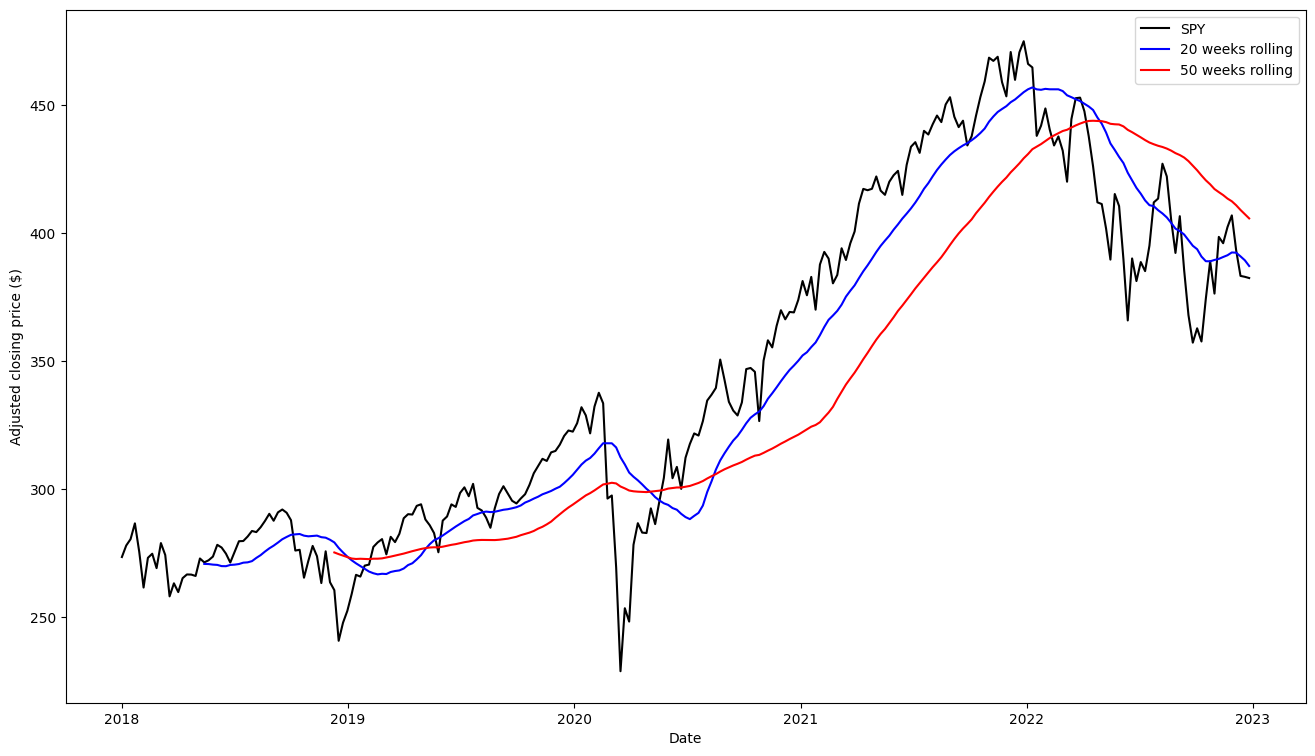

In [5]:
# Calculate the moving averages of the closing prices
fval = 20
sval = 50
short_rolling = close.rolling(window=fval).mean()
long_rolling = close.rolling(window=sval).mean()

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(close.index, close, label=ticker, color = 'k')
ax.plot(short_rolling.index, short_rolling, label=str(fval)+ ' weeks rolling',color = 'b')
ax.plot(long_rolling.index, long_rolling, label=str(sval)+' weeks rolling',color = 'r')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()


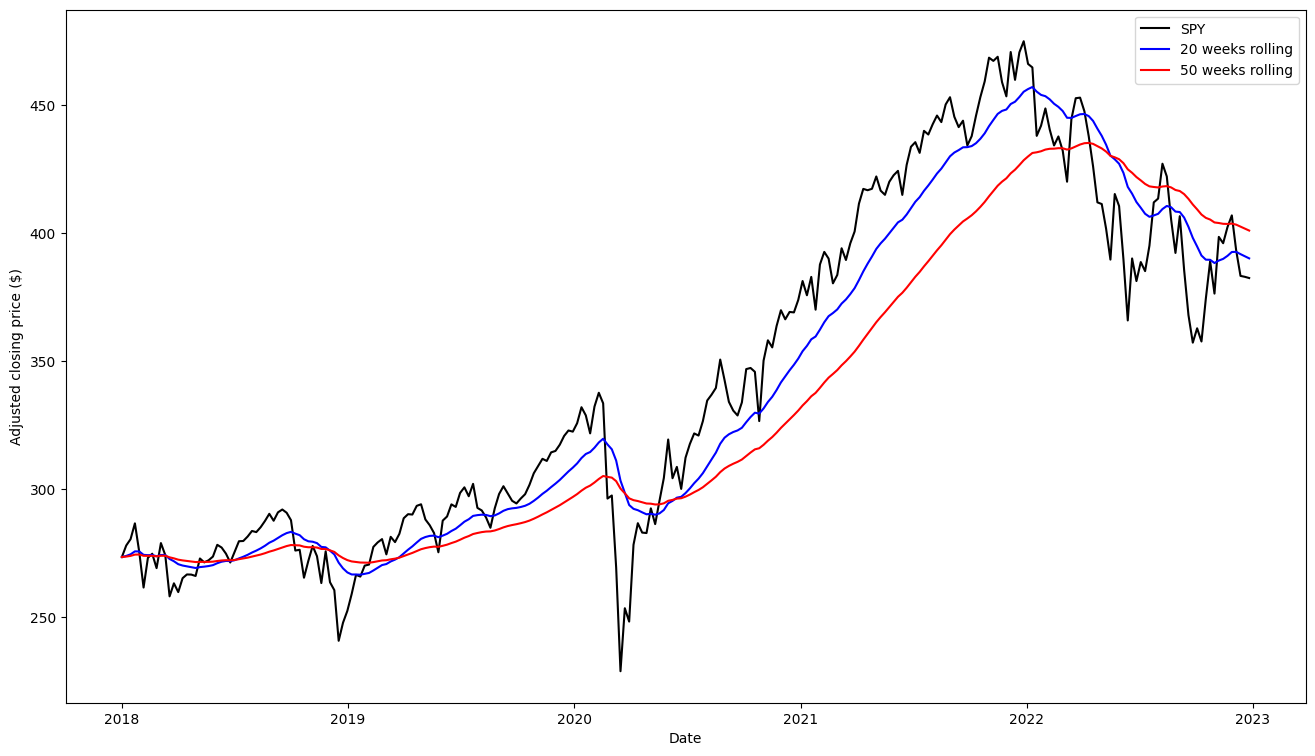

In [6]:
# Calculate the 20 and 50 days moving averages of the closing prices
short_rolling = close.ewm(span=fval, adjust=False).mean()
long_rolling = close.ewm(span=sval, adjust=False).mean()

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(close.index, close, label=ticker, color = 'k')
ax.plot(short_rolling.index, short_rolling, label=str(fval)+' weeks rolling',color = 'b')
ax.plot(long_rolling.index, long_rolling, label=str(sval)+' weeks rolling',color = 'r')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()

In [7]:
def MA_strategy1(close, fast_val, slow_val, sma = True):

  if sma:
    short_rolling = close.rolling(window=fast_val).mean()
    long_rolling = close.rolling(window=slow_val).mean()
  else:
    short_rolling = close.ewm(span=fast_val, adjust=False).mean()
    long_rolling = close.ewm(span=slow_val, adjust=False).mean()

  time_counter = 250
  profit_list = [ ]
  profit_info = [ ]
  profit = 0
  FF_loop_flag = True
  while FF_loop_flag:

    #FF to first up cross and save the entry price
    while FF_loop_flag and short_rolling[time_counter] <= long_rolling[time_counter]:
      time_counter += 1
      if time_counter >= len(short_rolling):
        FF_loop_flag = False
        time_counter -= 1
    entry_price = close[time_counter]

    #FF to first close below slow MA and save the entry price
    while FF_loop_flag and close[time_counter] >= long_rolling[time_counter]:
      time_counter += 1
      if time_counter >= len(short_rolling):
        FF_loop_flag = False
        time_counter -= 1
    exit_price = close[time_counter]
    profit = profit + (exit_price - entry_price)


    #FF to first MA down cross to set up for next buy signal
    while FF_loop_flag and short_rolling[time_counter] >= long_rolling[time_counter]:
      time_counter += 1
      if time_counter >= len(short_rolling):
        FF_loop_flag = False
        time_counter -= 1

  return profit



Fast MA with max profit =  39
Slow MA with max profit =  195
Max profit =  8.139984130859375


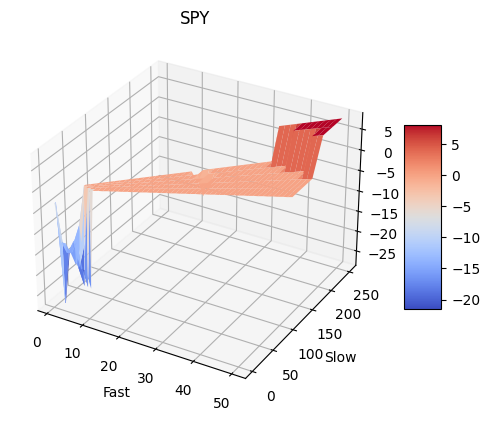

In [8]:
#set up slowperiod and fastperiod values
fastminval = 1
fastmaxval = 50
fastvec = list(range(fastminval, fastmaxval+1))
slowmult = [2.5,3,3.5,4,4.5,5]
slowlist = []
fastlist = []
for fastPeriod in fastvec:
  tmp_slow = []
  tmp_fast = []
  for multval in slowmult:
    tmp_slow.append(int(multval*fastPeriod))
    tmp_fast.append(fastPeriod)
  slowlist.append(tmp_slow)
  fastlist.append(tmp_fast)

#backtest each fastperiod/slowperiod pair
net_profit_list = []
for i in range(len(fastvec)):
  fastPeriod = fastvec[i]
  tmp_profit_list = []
  for slowPeriod in slowlist[i]:

    #print([fastPeriod,slowPeriod])
    tmp_profit_list.append(MA_strategy1(close, fastPeriod, slowPeriod, sma = False))

  net_profit_list.append(tmp_profit_list)

#Surface plot of profitability ...
fast_length=len(fastvec)
slow_length=len(slowmult)
X = np.zeros((fast_length,slow_length))
Y = np.zeros((fast_length,slow_length))
Z = np.zeros((fast_length,slow_length))
for i in range(fast_length):
  for j in range(slow_length):
    X[i,j] = fastlist[i][j]
    Y[i,j] = slowlist[i][j]
    Z[i,j] = net_profit_list[i][j]

print()
maxptr = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
print('Fast MA with max profit = ', int(X[maxptr]))
print('Slow MA with max profit = ', int(Y[maxptr]))
print('Max profit = ', Z[maxptr])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(ticker)
ax.set_xlabel('Fast')
ax.set_ylabel('Slow')
ax.set_zlabel('Profit $')
plt.show()

